In [4]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.bernoulli import Bernoulli as bn

## 生成随机数

In [5]:
def rbf_kernel(theta, x1, x2):
    assert x1.shape[1]==x2.shape[1],'dimension does not match'
    theta0 = theta[0]
    theta1 = theta[1]
    N1=x1.shape[0]
    N2=x2.shape[0]
    D=x1.shape[1]
    a=x1.reshape(N1,1,D)
    b=x2.reshape(1,N2,D)
    return theta0*torch.exp(-theta1/2*torch.sum((a-b)**2,dim=2))

In [6]:
def rbf_kernel_mo_hete(W, theta, x1, x2=None):
    assert W.shape[1] == len(theta), 'dimension of latent functions does not match'
    assert W.shape[0] == len(x1), 'number of tasks does not match'
    if x2 != None:
        assert W.shape[0] == len(x2), 'number of tasks does not match'
        len_x1 = [len(x) for x in x1]
        len_x2 = [len(y) for y in x2]
        Z = len(theta)
        cov_hete = torch.zeros((sum(len_x1), sum(len_x2)))
        for i, x in enumerate(x1):
            for j, y in enumerate(x2):
                K = torch.zeros(x.shape[0], y.shape[0])
                for z in range(Z):
                    K += W[i, z]*W[j, z]*rbf_kernel(theta[z], x, y)
                cov_hete[sum(len_x1[:i]):sum(len_x1[:(i+1)]), sum(len_x2[:j]):sum(len_x2[:(j+1)])] += K
        return cov_hete
    else:
        len_x1 = [len(x) for x in x1]
        Z = len(theta)
        cov_hete = torch.zeros((sum(len_x1), sum(len_x1))) + torch.eye(sum(len_x1))*1e-3
        for i, x in enumerate(x1):
            for j, y in enumerate(x1):
                K = torch.zeros(x.shape[0], y.shape[0])
                for z in range(Z):
                    K += W[i, z]*W[j, z]*rbf_kernel(theta[z], x, y)
                cov_hete[sum(len_x1[:i]):sum(len_x1[:(i+1)]), sum(len_x1[:j]):sum(len_x1[:(j+1)])] += K
        return cov_hete


In [7]:
num_client = 5
num_reg = 1
num_cla = 1
theta = torch.tensor([[1., 0.02], [2., 0.01]])
w = torch.tensor([[0.6, 0.4], [0.4, 0.6]])
data_size = 100
sigma2 = [1.]
xrange = 100

param_dict = {'num_client': num_client, 'num_reg':num_reg, 'num_cla':num_cla, 'theta':theta.tolist(), 'w':w.tolist(), 'data_size':data_size, 'sigma2':sigma2, 'xrange':xrange}

In [8]:
train_data = dict()
for i in range(num_client):
    x_reg = [torch.rand((data_size, 1)) * 100 for _ in range(num_reg)]
    x_cla = [torch.rand((data_size, 1)) * 100 for _ in range(num_cla)]

    K = rbf_kernel_mo_hete(w, theta, x_reg + x_cla)

    g = mvn(loc=torch.zeros(data_size*(num_reg+num_cla)), covariance_matrix=K).rsample()
    g_reg = [g[i*data_size: (i+1)*data_size] for i in range(num_reg)]
    g_cla = [g[data_size*num_reg+i*data_size: data_size*num_reg+(i+1)*data_size] for i in range(num_cla)]

    y_reg = [mvn(loc=g_reg[i], covariance_matrix=torch.eye(data_size)*sigma2[i]).rsample() for i in range(num_reg)]
    # y_cla = [(torch.sigmoid(g_cla[i]) >= 0.5).long() for i in range(num_cla)]
    y_cla = [bn(probs=torch.sigmoid(g_cla[i])).sample() for i in range(num_cla)]
    for cla in y_cla:
        cla[cla == 0] = -1
    
    x_reg, g_reg, y_reg = torch.concat(x_reg, dim=-1), torch.concat(g_reg, dim=-1), torch.concat(y_reg, dim=-1)
    x_cla, g_cla, y_cla = torch.concat(x_cla, dim=-1), torch.concat(g_cla, dim=-1), torch.concat(y_cla, dim=-1)
    train_data[i] = {"x_reg":x_reg, "g_reg":g_reg, "y_reg":y_reg, "x_cla":x_cla, "g_cla":g_cla, "y_cla": y_cla}

In [9]:
save_path = "./syn_f1"
os.makedirs(save_path, exist_ok=True)
with open(os.path.join(save_path, 'param.json'), "w") as f:
    json.dump(param_dict, f)
torch.save(train_data, os.path.join(save_path, "data.pth"))

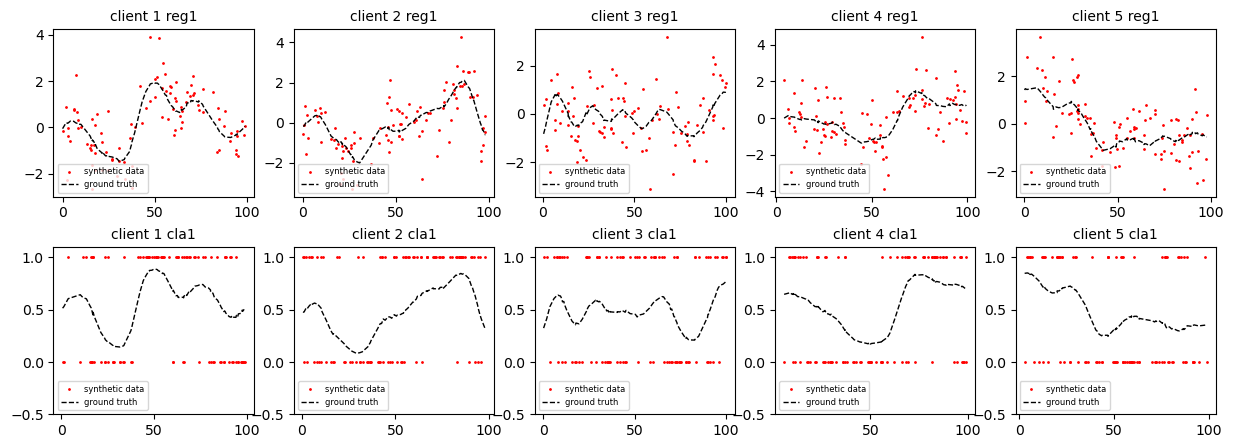

In [11]:
train = torch.load("./syn_f1/data.pth")
with open("./syn_f1/param.json", "r") as f:
    params = json.load(f)
trainsize = params['data_size']
num_tasks = params['num_reg']+params['num_cla']
num_client = params['num_client']
plt.rcParams['legend.fontsize'] = 6
plt.figure(figsize = (num_client*3, num_tasks*2.5))
for id in range(num_client):
    for i in range(params['num_reg']):
        x = train[id]['x_reg'][i*trainsize: (i+1)*trainsize].reshape(-1)
        g = train[id]['g_reg'][i*trainsize: (i+1)*trainsize]
        y = train[id]['y_reg'][i*trainsize: (i+1)*trainsize]
        plt.subplot(num_tasks, num_client, i*num_client+id+1)
        plt.scatter(x, y, marker='o', s=1, c='red', label='synthetic data')
        plt.plot(torch.sort(x)[0], g[torch.sort(x)[1]], linewidth=1, linestyle='--', c='k', label='ground truth')
        # plt.ylim(-2.5, 2.5)
        plt.title(f"client {id+1} reg{i+1}", fontsize=10)
        plt.legend(loc='lower left')
    for i in range(params['num_cla']):
        x = train[id]['x_cla'][i*trainsize: (i+1)*trainsize].reshape(-1)
        g = train[id]['g_cla'][i*trainsize: (i+1)*trainsize]
        y = train[id]['y_cla'][i*trainsize: (i+1)*trainsize]
        y[y == -1] = 0
        plt.subplot(num_tasks, num_client, num_client*(params['num_reg']+i)+id+1)
        plt.scatter(x[y == 0], [0]*len(y[y==0]), marker='o', c='red', s=1, label='synthetic data')
        plt.scatter(x[y == 1], [1]*len(y[y==1]), marker='o', c='red', s=1)
        plt.plot(torch.sort(x)[0], torch.sigmoid(g[torch.sort(x)[1]]), c='k', linewidth=1, linestyle='--', label='ground truth')
        plt.ylim(-0.5, 1.1)
        plt.title(f"client {id+1} cla{i+1}", fontsize=10)
        plt.legend(loc='lower left')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
